<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Ice-age dynamics: 9. Landscape
## Erosion (fluvial incision, sedimentation)
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we model **chemical weathering** with a **transport equation**.

We first initialize the `python` libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Model

The change in elevation $\frac{\partial h}{\partial t}$ is modelled as **transport equation**, 
the change depends on the slope $s$ and the runoff $Q$, which control the sediment
load $C_i$.

$$
\begin{array}{rcl}
 \left( \frac{\partial h}{\partial t} \right)_{sediment} & = & \frac{C_i - C_i^e}{A_i}, C_i > C_i^e \\
 \left( \frac{\partial h}{\partial t} \right)_{erosion}       & = & -\frac{C_i}{w_i L_e}, C_i < C_i^e \\
 C_i^e                                                              & = & \kappa_R s_i Q_i \\
 w_i                                                                & = & w_R \sqrt{Q_i}
\end{array}
$$

The **erosion rate** $\kappa_R$ [-],
the slope $s_i$,
the channel scale $L_e$,
and the runoff $Q$ [m$^3$/s] control the denudation response.

| variable       | name             |unit       |
|----------------|------------------|-----------|
| $h$            | surface          | [m]       |
| $t$            | time             | [s]       |
| $s_i$          | slope            | [-]       |
| $A_i$          | area             | [m$^2$]   |
| $w_i$          | river width      | [m]       |
| $C_i$          | sediment         | [m$^3$/s] |
| $C_i^e$        | carrying capacity| [m$^3$/s] |
| **Climate**    | -                |           |
|  $Q$           | runoff           | [m$^3$/s] |
| **Lithology**  | -                |           |
|  $\kappa_R$    | erosion rate     | [-]       |
|  $w_R$         | channel constant | [-]       |
|  $L_e$         | channel scale    | [m]       |

## Create grid and initial topography

Make an asymmetrical model with peak height `hmax` over a profile length `length`.

In [2]:
def erosion_init(nx=101,length=100e3,hmin=0.,hmax=1000.):
    """
    function creates an initial 1D topography
    over profile length
    with hmin and hmax as extreme values
        length [m] default: 100.e3  ! length of profile
        hmin [m]   default: 0.      ! min. topography
        hmax [m]   default: 1000.   ! max. topography
    """
    x    = np.linspace(0,length,nx)
    h = np.zeros(nx)
    h[x <= 0.4*length] = hmin + (hmax-hmin)*x[x <= 0.4*length] / (0.4*length)
    h[x >  0.4*length] = hmin + (hmax-hmin)*(length-x[x >  0.4*length]) / (length-0.4*length)

    tsave = np.zeros(10)
    topo = np.zeros(10*nx).reshape(10,nx)
    tsave[0] = 0.
    topo[0,:] = h
    #print(tsave.shape)
    #print(topo.shape)
    return x,h,tsave,topo,nx,length,hmin,hmax

In [3]:
x,h,tsave,topo,nx,length,hmin,hmax = erosion_init()

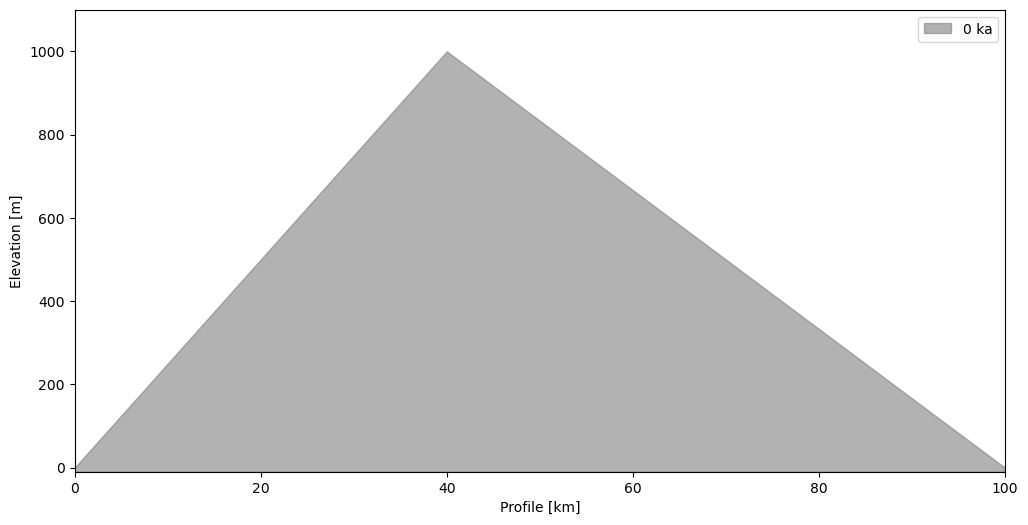

In [4]:
plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
plt.fill_between(x/1000,-10,topo[0,:],color='gray',alpha=0.6,label=str(int(tsave[0]/1000))+' ka')
plt.legend()

## Finite differences
Reformulate **partial differential equation** into **finite differences**:

We first need to rewrite the **differential equation** into one dimension ...
$$
\begin{array}{rcl}
\frac{h(t_i)-h(t_{i-1})}{\Delta t} = \frac{C_i - C_i^e}{A_i}, C_i > C_i^e \\
\frac{h(t_i)-h(t_{i-1})}{\Delta t} = -  \frac{C_i}{w_i L_e}, C_i < C_i^e
\end{array}
$$

Then solve for the current time step:
$$
\begin{array}{rcl}
h(t_i) = h(t_{i-1}) +  \frac{C_i - C_i^e}{A_i} \Delta t, C_i > C_i^e \\
h(t_i) = h(t_{i-1}) -  \frac{C_i}{w_i L_e} \Delta t, C_i < C_i^e 
\end{array}
$$

The transport part has to be coded explicitly. In 1D, we use a rather simple approach:

- We assume, the initial landscape has only one peak (summit).
- We first seach for this peak in the topography (use `amax` and `where` from the `numpy` library).
- We then define a **left** and a **right** part of the surface, over which water flows down.
- In these two loops, **water** and **sediment** is collected and handed down.

Note: In 2D, a more sophisticated approach is needed!

In [10]:
def erosion_loop(x,h,tsave,topo,nx,length,hmin,hmax,dtime=1e2,dtsave=1e5,endtime=5e5,uplift=0.,
                 xkf=0.08,l_BR=100e3,wr=0.1,rain=500.):
    """
    function applies long-range processes via a 1D transport equation
    over a given time window endtime, distretised into dtime intervals
        endtime  = 5.e5            # yr          ! total runtime
        dtime    = 1.e2            # yr          ! time increment
        dtsave   = 1.e5            # yr          ! saving interval
        length   = 100.e3          # m           ! length of profile
        hmin     = 0.              # m           ! min. topography
        hmax     = 1000.           # m           ! max. topography
        uplift   = 0.e-3           # m/s         ! uplift rate
        rain     = 500.            # mm/yr       ! runoff
        xkf      = 0.080           # -           ! erosion constant
        l_BR     = 100.e3          # m           ! bedrock erosion length scale
        wr       = 0.1             # sqrt(s/m)   ! channel width constant
    """
    dh = np.zeros(nx)
    dx = x[1] - x[0]
    
    time = 0.
    save = dtsave
    isave = 0

    while time < endtime:
        # loop over time
        time = time + dtime
        # apply uplift
        h[x <= 0.4*length] = h[x <= 0.4*length] + uplift*dtime*x[x <= 0.4*length] / (0.4*length)
        h[x >  0.4*length] = h[x >  0.4*length] + uplift*dtime*(length-x[x >  0.4*length]) / (length-0.4*length)
        # check for peak elevation
        ipeak = int(np.where(h == np.amax(h))[0])
        water = np.ones(nx)*rain*1.e-3*dx**2
        sediment = np.zeros(nx)
        # right of summit
        for i in range(ipeak,nx-1):
            channel_slope = (h[i]-h[i+1]) / (np.sqrt((x[i]-x[i+1])**2))
            capacity      = xkf*channel_slope*water[i]*dtime
            channel_width = wr*np.sqrt(water[i])
            if (sediment[i] >= capacity):
                dh[i] = (sediment[i]-capacity) / dx / dx
            else:
                dh[i] = -capacity / (channel_width*l_BR)
                dsedi = -dh[i]*dx*dx
                sediment[i] = sediment[i] + dsedi
            water[i+1] =water[i+1] + water[i]
            sediment[i+1] =sediment[i+1] + sediment[i]
        # left of summit
        for i in range(ipeak,0,-1):
            channel_slope = (h[i]-h[i-1]) / (np.sqrt((x[i]-x[i-1])**2))
            capacity      = xkf*channel_slope*water[i]*dtime
            channel_width = wr*np.sqrt(water[i])
            if (sediment[i] >= capacity):
                dh[i] = (sediment[i]-capacity) / dx / dx
            else:
                dh[i] = -capacity / (channel_width*l_BR)
                dsedi = -dh[i]*dx*dx
                sediment[i] = sediment[i] + dsedi
            water[i-1] =water[i-1] + water[i]
            sediment[i-1] =sediment[i-1] + sediment[i]
        
        # apply erosion
        h = h + dh
        # save intermediate time step
        if (time==save):
            print(save,ipeak)
            isave = isave + 1
            topo[isave,:] = h
            tsave[isave]  = time
            save = save + dtsave
    return isave,tsave,topo

----
## No uplift, temporal evolution

100000.0 40
200000.0 40
300000.0 40
400000.0 40
500000.0 41


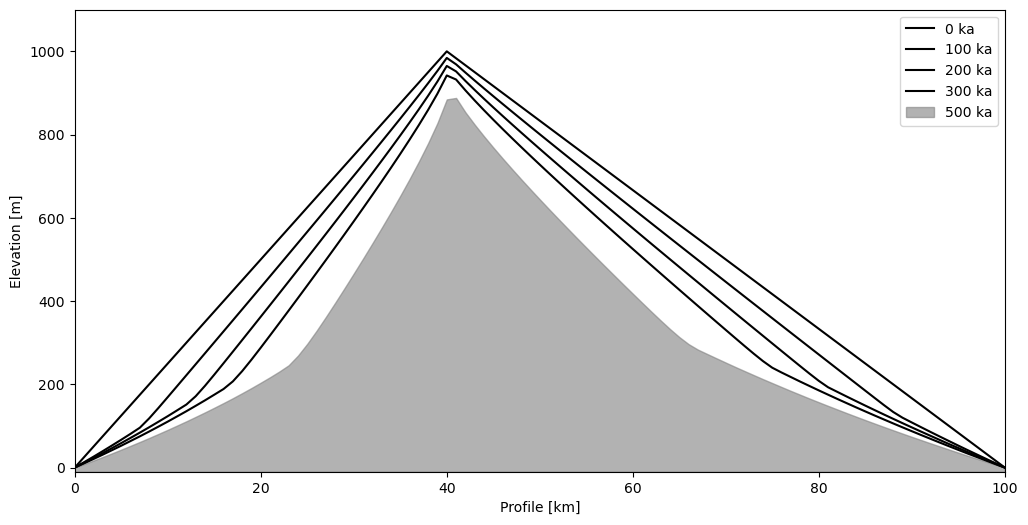

In [11]:
x,h,tsave,topo,nx,length,hmin,hmax = erosion_init()
isave,tsave,topo = erosion_loop(x,h,tsave,topo,nx,length,hmin,hmax)

plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
for i in range(isave-1):
    plt.plot(x/1000,topo[i,:],color='black',linestyle='-',label=str(int(tsave[i]/1000))+' ka')
plt.fill_between(x/1000,-10,topo[isave,:],color='gray',alpha=0.6,label=str(int(tsave[isave]/1000))+' ka')
plt.legend()

----
## Uplift, temporal evolution

100000.0 40
200000.0 40
300000.0 40
400000.0 40
500000.0 40


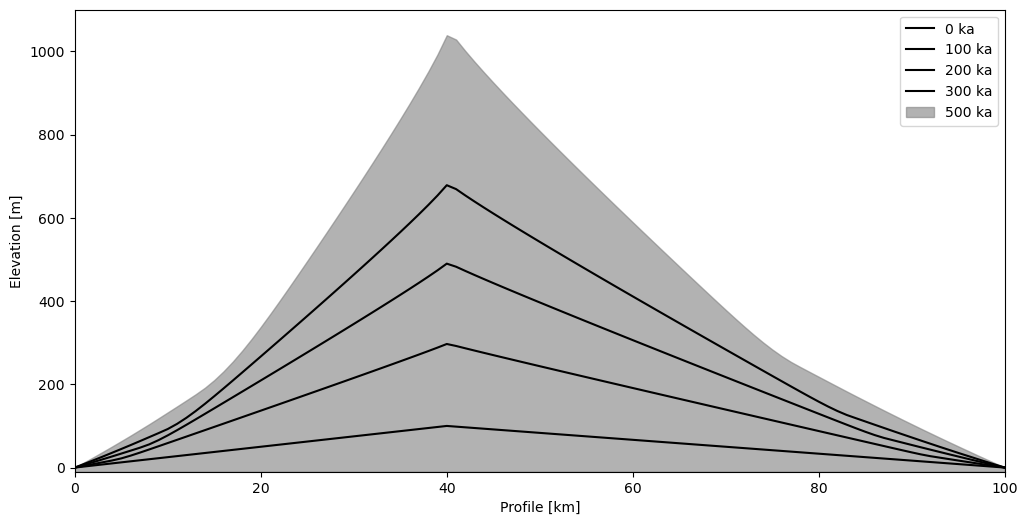

In [12]:
x,h,tsave,topo,nx,length,hmin,hmax = erosion_init(hmax=100.)
isave,tsave,topo = erosion_loop(x,h,tsave,topo,nx,length,hmin,hmax,uplift=2e-3)

plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
for i in range(isave-1):
    plt.plot(x/1000,topo[i,:],color='black',linestyle='-',label=str(int(tsave[i]/1000))+' ka')
plt.fill_between(x/1000,-10,topo[isave,:],color='gray',alpha=0.6,label=str(int(tsave[isave]/1000))+' ka')
plt.legend()

... done